# Clustering German universities based on nightlife and fitness venues
## 1. Introduction/Business Problem
### Problem definition
In this project I want to look at universities in Germany. There are some 100 universities in Germany and it can be a challenging task to choose the right one. There are many reports and lists out there that assess universities based on the quality of their teaching and their reputation. This is of course one useful approach. 
But students do not just want to study all day long, they also want to have fun in the evening be it by going to a bar or excercising in a gym.

Therefore, I want to look at nightlife and fitness venues in the vicinity of each university. Based on that I want to calculate a metric that ranks universities by *venues or gyms per student*. In addition I will use K-means clustering in order to define different clusters of universities.
All the above will be visualized in maps.
### Audience
My main audience is students that are trying to find the right university. In addition to information that is already available in university rankings they could use my analysis to find an institute that has a high nightlife factor.
## 2. Data
### Universities (Wikipedia)
A list of universities in Germany is available on Wikipedia here: [Liste der Hochschulen in Deutschland](https://de.wikipedia.org/wiki/Liste_der_Hochschulen_in_Deutschland "Liste der Hochschulen in Deutschland")
The first column gives as the name of the university.
It contains information about the type ("Form") of institution. We will only look at universities ("Uni")
It also contains information on the number of students ("Studierende") which will be used in our analysis.

The table looks like this:

Name | Land | Form | Träger | Promotionsrecht| Gründung | Studierende | Stand
---|---|---|---|---|---|---:|---
FH Aachen | NW | FH | staatlich | nein | 1971| 13.671 | 2016/17 (WS)
RWTH Aachen | NW | Uni | staatlich | ja | 1870 | 45.628 | 2019/20 (WS)[4]
... |... |... |... |... |... |... |... 

### Geo data (Google)
In order to show the universities in a map of Germany we need geo information (longitude, latitude) that is not part of the wiki page. We will use the Geocoder API from Google Maps to obtain these coordinates
### Location data (Foursquare)
The information about nightlife and fitness venues will be obtained from Foursquare. We will focus on a radius of 1000-2000m around the university.
The venues that we are interested in will be retrieved by using the corresponding category IDs:

| Category | Category ID |
|---|----|
| Nightlife | 4d4b7105d754a06376d81259 |
| Fitness   | 4bf58dd8d48988d175941735 |


# Methodology

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why

# Results

Results section where you discuss the results

# Discussion

Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

# Code below (still work in progress)

In [124]:
import pandas as pd
import requests
import json
import bs4
import folium
from folium.plugins import MarkerCluster
from math import log
import googlemaps
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

Get list of German universities from Wikipedia (sorry, the site is German ...)

In [4]:
url = 'https://de.wikipedia.org/wiki/Liste_der_Hochschulen_in_Deutschland'
res = requests.get(url)
text = bs4.BeautifulSoup(res.text)

Find the table

In [5]:
mytable = text.find('table',{'class':'wikitable zebra sortable'})

Find headers and the data

In [6]:
header = [c.text.strip() for c in mytable.find('tr').find_all('th')] # find all th tags in first row
data = [[c.text.strip() for c in row.find_all('td')] for row in mytable.find_all('tr')] # find all td tags in all rows

Create the dataframe

In [7]:
df = pd.DataFrame(data=data, columns=header)

df.dropna(inplace=True)

df.reset_index(inplace=True, drop=True)

columns = ['Name', 'State', 'Type', 'Provider', 'PhD', 'Year_founded', 'Number_students', 'Data_as_of']
df.columns = columns
df.head()

Name  State Type   Provider  \
0                                          FH Aachen  NW NW   FH  staatlich   
1                                        RWTH Aachen  NW NW  Uni  staatlich   
2                                   Hochschule Aalen  BW BW   FH  staatlich   
3                    Hochschule Albstadt-Sigmaringen  BW BW   FH  staatlich   
4  Alanus Hochschule für Kunst und Gesellschaft (...  NW NW   FH     privat   

    PhD Year_founded                   Number_students       Data_as_of  
0  nein         1971  000000000013671.000000000013.671     2016/17 (WS)  
1    ja         1870  000000000045628.000000000045.628  2019/20 (WS)[4]  
2  nein         1962   000000000004970.00000000004.970     2012/13 (WS)  
3  nein         1971   000000000002925.00000000002.925     2012/13 (WS)  
4    ja         2002     000000000000914.0000000000914     2012/13 (WS)

In [8]:
df.shape

(425, 8)

Something went wrong with the *number of students*. Let us fix this.

In [9]:
df['Number_students'] = df['Number_students'].str.extract(r'^0+(\d+)')
df['Number_students'] = pd.to_numeric(df['Number_students'])

And the data in the *State* field is duplicated ...

In [10]:
df['State'] = df['State'].str.extract(r'^(\w+)')

Let us focus on universities only, i.e. Type is Uni

In [11]:
df = df[df['Type'] == 'Uni']

In [12]:
df.shape

(105, 8)

#### Get the geo information for the universities

Below is the code to get the geo information from Google Maps API. When the geo information has been received the resulting data frame is written to a CSV file locally. 
This is allows to read the information from the file (when it exists) instead of calling the API each time the code is run.

In [13]:
def get_geo_data(df):
    try:
        file = 'Universities.csv'
        df = pd.read_csv(file, index_col='Name')
        print('Geo data read from file {}'.format(file))
    except:
        google_key = input('Enter Google API key: ')
        gmaps = googlemaps.Client(key=google_key)

        # Create list of university names
        unis = df['Name']

        lat = {}
        lng = {}

        # Loop over universities, get geocoding information from Google Maps API and put the coordinates in dictionaries
        for uni in unis:
            print(uni, end=', ')
            geocode_result = gmaps.geocode('{}'.format(uni))
            lat[uni] = (geocode_result[0]['geometry']['location']['lat'])
            lng[uni] = (geocode_result[0]['geometry']['location']['lng'])

        # Make university name the index
        df.set_index('Name', drop=True, inplace=True)

        # Add the coordinates as new columns to the dataframe

        df['lat'] = pd.Series(lat)
        df['lng'] = pd.Series(lng)

        # Drop all data without coordinates
        df.dropna(inplace=True)

        # Save the dataframe to a csv
        df.to_csv('Universities.csv')
        
        print('Geo data retrieved from Google Maps API')
    return df

In [14]:
df = get_geo_data(df)

df.head()

Geo data read from file Universities.csv


State Type   Provider PhD Year_founded  \
Name                                                                        
RWTH Aachen                           NW  Uni  staatlich  ja         1870   
Universität Augsburg                  BY  Uni  staatlich  ja         1970   
Otto-Friedrich-Universität Bamberg    BY  Uni  staatlich  ja    1647/1972   
Universität Bayreuth                  BY  Uni  staatlich  ja         1975   
Freie Universität Berlin              BE  Uni  staatlich  ja         1948   

                                    Number_students       Data_as_of  \
Name                                                                   
RWTH Aachen                                 45628.0  2019/20 (WS)[4]   
Universität Augsburg                        20138.0     2018/19 (WS)   
Otto-Friedrich-Universität Bamberg          13119.0     2018/19 (WS)   
Universität Bayreuth                        12787.0     2016/17 (WS)   
Freie Universität Berlin                    38304.0     2019/20 (WS)   

                                          lat        lng  
Name                                                      
RWTH Aachen                         50.780078   6.065687  
Universität Augsburg                48.332631  10.896399  
Otto-Friedrich-Universität Bamberg  49.893834  10.886138  
Universität Bayreuth                49.928820  11.585831  
Freie Universität Berlin            52.454324  13.293477

Draw a map of all universities

In [15]:
# Use mean values of the coordinates as starting point for the map
latitude = df['lat'].mean()
longitude = df['lng'].mean()

In [16]:
# create map of Toronto using latitude and longitude values
map = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, state, uni, nbr in zip(df['lat'], df['lng'], df['State'], df.index.values, df['Number_students']):
    label = '{}, {}, {} students'.format(uni, state, nbr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3 + 3 / 8000 * nbr, # normalize the number of students in order to get a radius between 3 and 30
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

Get from Foursquare the *Nightlife* venues and the *Gym / Fitness Center* close to each university

In [48]:
categories = {'night': '4d4b7105d754a06376d81259', 'fit': '4bf58dd8d48988d175941735'}

radius = 2000
LIMIT = 300

CLIENT_ID = 'ANGPPJHHP4HPIVZXY5UOWY2ELW1Q4E3N5AKIZFTVADNA1DUA' # your Foursquare ID
CLIENT_SECRET = input('Enter your Foursquare Client Secret: ') # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Enter your Foursquare Client Secret:  WMU31HDXHROX02M20GUCLW2DWUFCVPTP3P4EDLYOTFLLI5VT


Function that gets the venues information from Foursquare

In [49]:
def get_nearby_venues(names, latitudes, longitudes, category, radius=radius):
    """
    Input: names, latitudes, longitudes
    Output: nearby venues as dataframe
    """
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, end='\r')
        
        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category)

        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except:
            results = {}
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['University', 
              'University Latitude', 
              'University Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

    return nearby_venues

Get the venues from Foursquare but only if they are not already saved to a file

In [58]:
try:
    file = 'venues.csv'
    venues = pd.read_csv(file, index_col=0)
    print('Geo data read from file {}'.format(file))
except:
    venues_night = get_nearby_venues(names=df.index.values, latitudes=df['lat'], longitudes=df['lng'], category=categories['night'])
    venues_fit = get_nearby_venues(names=df.index.values, latitudes=df['lat'], longitudes=df['lng'], category=categories['fit'])
    venues_night['category'] = 'Nightlife'
    venues_fit['category'] = 'Fitness'
    venues = pd.concat([venues_fit, venues_night])
    venues.to_csv('venues.csv')

Geo data read from file venues.csv


In [59]:
venues.head()

University  University Latitude  University Longitude  \
0  RWTH Aachen            50.780078              6.065687   
1  RWTH Aachen            50.780078              6.065687   
2  RWTH Aachen            50.780078              6.065687   
3  RWTH Aachen            50.780078              6.065687   
4  RWTH Aachen            50.780078              6.065687   

                                       Venue  Venue Latitude  Venue Longitude  \
0                        Selection Center 10       50.790991         6.065972   
1                         World of Fitness 3       50.787373         6.069295   
2              Fit and Spa Lounge Quellenhof       50.781958         6.090636   
3                          Selection Fitness       50.770582         6.060628   
4  tennis-squash & boule-center lichtenbusch       50.770621         6.083176   

         Venue Category category  
0                   Gym  Fitness  
1                   Gym  Fitness  
2                   Spa  Fitness  
3                   Gym  Fitness  
4  Gym / Fitness Center  Fitness

In [52]:
venues.shape

(3677, 8)

Plot the number of nearby venues per university (top 30)

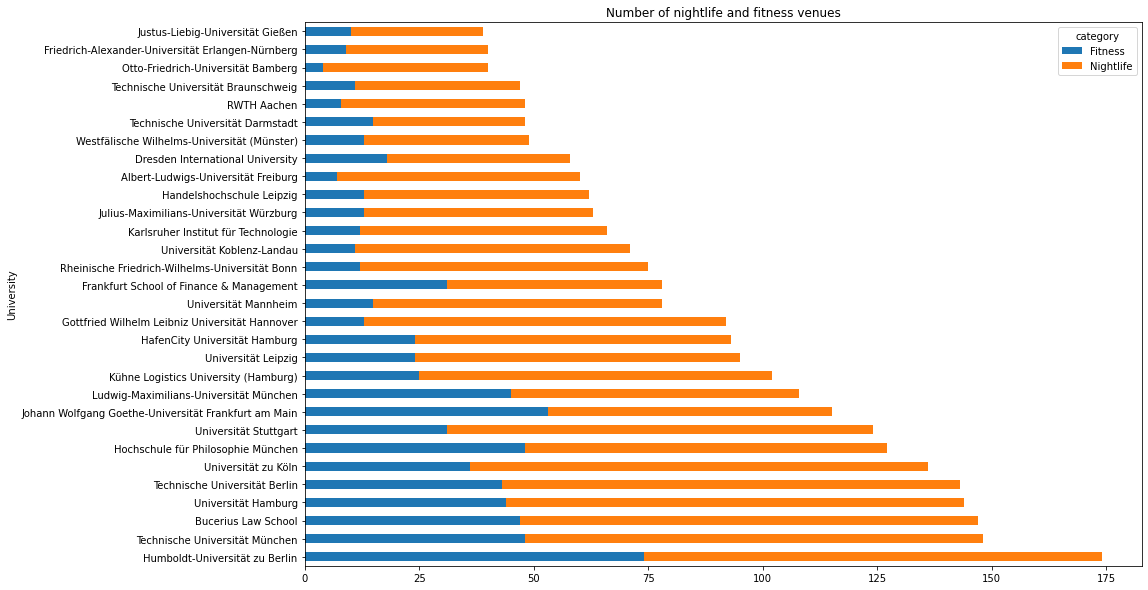

In [53]:
top = 30
venues_pivot = venues[['University', 'Venue', 'category']] \
    .pivot_table(values='Venue', index='University', columns='category', aggfunc='count') 

venues_pivot['Number of venues'] = venues_pivot.sum(axis = 1)
venues_pivot = venues_pivot.sort_values(by='Number of venues', ascending=False)
# venues_pivot.dropna(axis=1, how='all', inplace=True)
venues_pivot.iloc[:, 0:-1][:top].plot(kind='barh', figsize=(15,10), stacked=True, title='Number of nightlife and fitness venues')


Calculate a KPI of *nightlife and_or fitness venues per student*

In [73]:
venues_per_student = venues_pivot[['Number of venues']].join(df['Number_students'], lsuffix='venue_', rsuffix='university_', )
venues_per_student['ven_per_1000stud'] = venues_per_student['Number of venues'] / venues_per_student['Number_students'] * 1000
venues_per_student = venues_per_student.sort_values(by='ven_per_1000stud', ascending=False)
venues_per_student = venues_per_student.join(df[['lat', 'lng']])
venues_per_student.head()

Number of venues  \
University                                                             
Philosophisch-Theologische Hochschule Münster                   37.0   
Northern Institute of Technology Management (Ha...              13.0   
Kühne Logistics University (Hamburg)                           102.0   
Hochschule für Philosophie München                             127.0   
Theologische Fakultät Paderborn                                 21.0   

                                                    Number_students  \
University                                                            
Philosophisch-Theologische Hochschule Münster                  62.0   
Northern Institute of Technology Management (Ha...             30.0   
Kühne Logistics University (Hamburg)                          253.0   
Hochschule für Philosophie München                            336.0   
Theologische Fakultät Paderborn                                92.0   

                                                    ven_per_1000stud  \
University                                                             
Philosophisch-Theologische Hochschule Münster             596.774194   
Northern Institute of Technology Management (Ha...        433.333333   
Kühne Logistics University (Hamburg)                      403.162055   
Hochschule für Philosophie München                        377.976190   
Theologische Fakultät Paderborn                           228.260870   

                                                          lat        lng  
University                                                                
Philosophisch-Theologische Hochschule Münster       51.970520   7.606977  
Northern Institute of Technology Management (Ha...  53.462575   9.969569  
Kühne Logistics University (Hamburg)                53.540467   9.994335  
Hochschule für Philosophie München                  48.148793  11.583367  
Theologische Fakultät Paderborn                     51.716102   8.755151

Number of venues  \
University                                                             
Philosophisch-Theologische Hochschule Münster                   37.0   
Northern Institute of Technology Management (Ha...              13.0   
Kühne Logistics University (Hamburg)                           102.0   
Hochschule für Philosophie München                             127.0   
Theologische Fakultät Paderborn                                 21.0   

                                                    Number_students  \
University                                                            
Philosophisch-Theologische Hochschule Münster                  62.0   
Northern Institute of Technology Management (Ha...             30.0   
Kühne Logistics University (Hamburg)                          253.0   
Hochschule für Philosophie München                            336.0   
Theologische Fakultät Paderborn                                92.0   

                                                    ven_per_1000stud  \
University                                                             
Philosophisch-Theologische Hochschule Münster             596.774194   
Northern Institute of Technology Management (Ha...        433.333333   
Kühne Logistics University (Hamburg)                      403.162055   
Hochschule für Philosophie München                        377.976190   
Theologische Fakultät Paderborn                           228.260870   

                                                          lat        lng  
University                                                                
Philosophisch-Theologische Hochschule Münster       51.970520   7.606977  
Northern Institute of Technology Management (Ha...  53.462575   9.969569  
Kühne Logistics University (Hamburg)                53.540467   9.994335  
Hochschule für Philosophie München                  48.148793  11.583367  
Theologische Fakultät Paderborn                     51.716102   8.755151

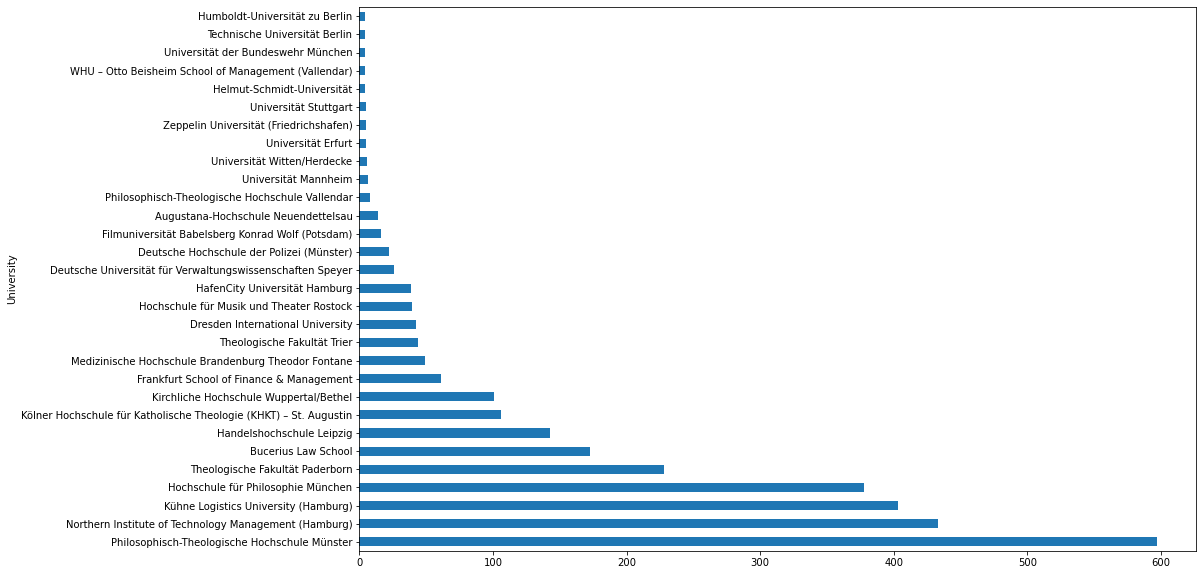

In [72]:
venues_per_student['ven_per_1000stud'][:30].plot(kind='barh', figsize=(15,10))


Draw a map with location of all venues

In [105]:
# create map of Germany with all venues close to universities

from folium.plugins import MarkerCluster

map2 = folium.Map(location=[latitude, longitude], zoom_start=6)

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)

locationlist = list(zip(venues['Venue Latitude'].to_list(), venues['Venue Longitude'].to_list()))
venuelist = venues['Venue'].to_list()

for point in range(0, len(venuelist)):
    folium.Marker(locationlist[point], venuelist[point]).add_to(marker_cluster)
map2

Draw a new map that visualizes the KPI and puts a focus on a high nightlife intensity

In [69]:
venues_per_uni = venues_pivot[['Number of venues']].join(df[['lat', 'lng']])

# create map of Toronto using latitude and longitude values
map = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, name, nbr in zip(venues_per_uni['lat'], venues_per_uni['lng'], venues_per_uni.index.values, venues_per_uni['Number of venues']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 4.3 + 0.14 * nbr, # normalize the number of students in order to get a radius between 3 and 30
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

#### Create a new map where the size of the bubble represents the number of venues per student 

In [76]:
# create map of Toronto using latitude and longitude values
map3 = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, name, nbr in zip(venues_per_student['lat'], venues_per_student['lng'], venues_per_student.index.values, venues_per_student['ven_per_1000stud']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 4.7 + 0.08 * nbr, # normalize the number of students in order to get a radius between 3 and 30
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map3

### Cluster the universities by using k-means

# Trial Area

In [136]:
# one hot encoding
unis_onehot = pd.get_dummies(venues[['category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
unis_onehot['University'] = venues['University'] 

# move neighborhood column to the first column
fixed_columns = [unis_onehot.columns[-1]] + list(unis_onehot.columns[:-1])
unis_onehot = unis_onehot[fixed_columns]

unis_onehot.head()

University  Fitness  Nightlife
0  RWTH Aachen        1          0
1  RWTH Aachen        1          0
2  RWTH Aachen        1          0
3  RWTH Aachen        1          0
4  RWTH Aachen        1          0

In [185]:
unis_grouped = unis_onehot.groupby('University').sum().reset_index()
unis_grouped = unis_grouped.join(df['Number_students'], on='University')
unis_grouped['Number_venues'] = unis_grouped['Fitness'] + unis_grouped['Nightlife']
unis_grouped.head()

University  Fitness  Nightlife  \
0                Albert-Ludwigs-Universität Freiburg        7         53   
1                Augustana-Hochschule Neuendettelsau        0          2   
2                         Bauhaus-Universität Weimar        3         11   
3                    Bergische Universität Wuppertal        7         13   
4  Brandenburgische Technische Universität Cottbu...        5          5   

   Number_students  Number_venues  
0          24892.0             60  
1            147.0              2  
2           4172.0             14  
3          22061.0             20  
4           7280.0             10

In [197]:
kclusters = 10

unis_grouped_clustering = unis_grouped[['Number_students', 'Number_venues']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(unis_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 6, 8, 6, 1, 8, 0, 1, 6])

In [198]:
try:
    df.drop(columns='Cluster', axis=1, inplace=True)
    df.insert(0, 'Cluster', kmeans.labels_)
except:
    df.insert(0, 'Cluster', kmeans.labels_)
df.head()

Cluster State Type   Provider PhD  \
Name                                                                    
RWTH Aachen                               0    NW  Uni  staatlich  ja   
Universität Augsburg                      1    BY  Uni  staatlich  ja   
Otto-Friedrich-Universität Bamberg        6    BY  Uni  staatlich  ja   
Universität Bayreuth                      8    BY  Uni  staatlich  ja   
Freie Universität Berlin                  6    BE  Uni  staatlich  ja   

                                   Year_founded  Number_students  \
Name                                                               
RWTH Aachen                                1870          45628.0   
Universität Augsburg                       1970          20138.0   
Otto-Friedrich-Universität Bamberg    1647/1972          13119.0   
Universität Bayreuth                       1975          12787.0   
Freie Universität Berlin                   1948          38304.0   

                                         Data_as_of        lat        lng  
Name                                                                       
RWTH Aachen                         2019/20 (WS)[4]  50.780078   6.065687  
Universität Augsburg                   2018/19 (WS)  48.332631  10.896399  
Otto-Friedrich-Universität Bamberg     2018/19 (WS)  49.893834  10.886138  
Universität Bayreuth                   2016/17 (WS)  49.928820  11.585831  
Freie Universität Berlin               2019/20 (WS)  52.454324  13.293477

In [199]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, uni, cluster in zip(df['lat'], df['lng'], df.index.values, df['Cluster']):
    label = folium.Popup(uni + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [200]:
unis_grouped.head()

University  Fitness  Nightlife  \
0                Albert-Ludwigs-Universität Freiburg        7         53   
1                Augustana-Hochschule Neuendettelsau        0          2   
2                         Bauhaus-Universität Weimar        3         11   
3                    Bergische Universität Wuppertal        7         13   
4  Brandenburgische Technische Universität Cottbu...        5          5   

   Number_students  Number_venues  
0          24892.0             60  
1            147.0              2  
2           4172.0             14  
3          22061.0             20  
4           7280.0             10

In [201]:
df.head()

Cluster State Type   Provider PhD  \
Name                                                                    
RWTH Aachen                               0    NW  Uni  staatlich  ja   
Universität Augsburg                      1    BY  Uni  staatlich  ja   
Otto-Friedrich-Universität Bamberg        6    BY  Uni  staatlich  ja   
Universität Bayreuth                      8    BY  Uni  staatlich  ja   
Freie Universität Berlin                  6    BE  Uni  staatlich  ja   

                                   Year_founded  Number_students  \
Name                                                               
RWTH Aachen                                1870          45628.0   
Universität Augsburg                       1970          20138.0   
Otto-Friedrich-Universität Bamberg    1647/1972          13119.0   
Universität Bayreuth                       1975          12787.0   
Freie Universität Berlin                   1948          38304.0   

                                         Data_as_of        lat        lng  
Name                                                                       
RWTH Aachen                         2019/20 (WS)[4]  50.780078   6.065687  
Universität Augsburg                   2018/19 (WS)  48.332631  10.896399  
Otto-Friedrich-Universität Bamberg     2018/19 (WS)  49.893834  10.886138  
Universität Bayreuth                   2016/17 (WS)  49.928820  11.585831  
Freie Universität Berlin               2019/20 (WS)  52.454324  13.293477

In [202]:
result_df = unis_grouped.join(df['Cluster'], on='University')
result_df.set_index('University', inplace=True)
mask0 = result_df['Cluster'] == 0
result_df[mask0]

Fitness  Nightlife  \
University                                                        
Eberhard Karls Universität Tübingen                2         21   
Fernuniversität in Hagen                           3          5   
RWTH Aachen                                        8         40   
Technische Universität Ilmenau                     4          6   
Universität Bielefeld                              3          5   
Universität Bremen                                 4          5   
Universität Potsdam                                4          5   
Universität zu Lübeck                              4          5   
Westfälische Wilhelms-Universität (Münster)       13         36   

                                             Number_students  Number_venues  \
University                                                                    
Eberhard Karls Universität Tübingen                  27833.0             23   
Fernuniversität in Hagen                             75404.0              8   
RWTH Aachen                                          45628.0             48   
Technische Universität Ilmenau                        5608.0             10   
Universität Bielefeld                                24875.0              8   
Universität Bremen                                   18843.0              9   
Universität Potsdam                                  20609.0              9   
Universität zu Lübeck                                 4341.0              9   
Westfälische Wilhelms-Universität (Münster)          45721.0             49   

                                             Cluster  
University                                            
Eberhard Karls Universität Tübingen                0  
Fernuniversität in Hagen                           0  
RWTH Aachen                                        0  
Technische Universität Ilmenau                     0  
Universität Bielefeld                              0  
Universität Bremen                                 0  
Universität Potsdam                                0  
Universität zu Lübeck                              0  
Westfälische Wilhelms-Universität (Münster)        0

In [ ]:
from sklearn.preprocessing import Normalizer
X = unis_grouped[[ 'Nightlife']].values
transformer = Normalizer().fit(X)  # fit does nothing.
transformer

transformer.transform(X)

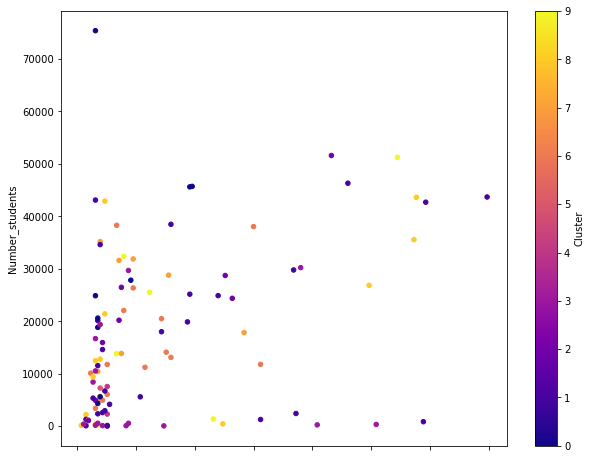

In [204]:
result_df.plot(kind='scatter', x='Number_venues', y='Number_students', c='Cluster', colormap='plasma', figsize=(10,8))

#### Representation of venues per student

There are many small bubbles on the map an only very few large bubbles. The large bubbles are driven by small number of students at these universities. 
The spectrum should be represented more evenly. Maybe by using a log scale?

#### Grouping of cities

It could be interesting to look at cities rather than universities. That would give a better understanding of venues per student per location (rather than per university).